In [ ]:
using_colab = True
if using_colab: 
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path="/content/drive/MyDrive/archive"
work_path="/content/drive/MyDrive/CV"

The following code is copied from Kaggle with slight modifications due to some bugs encountered.

In [ ]:
import json

# Đường dẫn đến file JSON
file_path_train = dataset_path+'/train/_annotations.coco.json'
file_path_valid = dataset_path+'/valid/_annotations.coco.json'
file_path_test = dataset_path+'/test/_annotations.coco.json'


# Đọc file JSON
with open(file_path_train, 'r') as file:
    data_train = json.load(file)

with open(file_path_valid, 'r') as file:
    data_valid = json.load(file)

with open(file_path_test, 'r') as file:
    data_test = json.load(file)

In [ ]:
categories_train = data_train['categories']
images_train = data_train['images']
annotations_train = data_train['annotations']

categories_valid = data_valid['categories']
images_valid = data_valid['images']
annotations_valid = data_valid['annotations']

categories_test = data_test['categories']
images_test = data_test['images']
annotations_test = data_test['annotations']

In [ ]:
def create_maskGt(segmentations, input_image):
  """
  Creates a mask from a list of segmentations.

  Args:
    segmentations: A list of segmentation polygons.
    input_image: The input image.

  Returns:
    A PIL Image object representing the mask.
  """

  mask = np.zeros((input_image.height, input_image.width))
  for seg in segmentations:
    poly = np.array(seg).reshape((-1, 2))  # Chuyển đổi sang mảng numpy và định dạng lại
    img_poly = Polygon(poly)
    x, y = np.meshgrid(np.arange(input_image.width), np.arange(input_image.height))  # Tạo lưới điểm cho hình ảnh
    x, y = x.flatten(), y.flatten()
    points = np.vstack((x,y)).T

    path = img_poly.get_path()  # Lấy đường dẫn của đa giác
    grid = path.contains_points(points)
    grid = grid.reshape((input_image.height, input_image.width))  # Định dạng lại cho phù hợp với kích thước hình ảnh
    mask[grid] = 1  # Cập nhật mặt nạ


  return mask

In [ ]:
import matplotlib.pyplot as plt

def visualize_masks(image, mask_gt, mask_pred_classic, mask_pred_finetune, figsize=(15, 15)):
    """
    Visualizes two masks side-by-side, along with the original image.

    Args:
        image: The original image.
        mask_gt: The ground truth mask.
        mask_gd: The predicted mask.
        figsize: The size of the figure.
    """

    # Create a new figure with three subplots.
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    # Plot the ground truth mask on the second subplot.
    axes[0].imshow(image)
    axes[0].imshow(mask_gt, alpha =0.5)
    axes[0].set_title("Ground Truth Mask")

    # Plot the predicted mask on the third subplot.
    axes[1].imshow(image)
    axes[1].imshow(mask_pred_classic, alpha =0.5)
    axes[1].set_title("Predicted Mask Classic")

    # Plot the predicted mask on the third subplot.
    axes[2].imshow(image)
    axes[2].imshow(mask_pred_finetune, alpha =0.5)
    axes[2].set_title("Predicted Mask Finetune")

    # Show the figure.
    plt.show()

In [ ]:
# you can choose to compute those directly instead by setting this flag to False
loading_lists=True

from PIL import Image
import numpy as np
from matplotlib.patches import Polygon

if not loading_lists:
  file_path_train = dataset_path+'/train/'
  file_path_val = dataset_path+'/valid/'
  file_path_test = dataset_path+'/test/'

  imgs_train = []
  for image in images_train:
      imgs_train.append(Image.open(file_path_train + image['file_name']))

  msks_train = []
  for i in range(len(imgs_train)):
      mask = create_maskGt(annotations_train[i]['segmentation'],imgs_train[i])
      msks_train.append(mask)

  imgs_val = []
  for image in images_valid:
      imgs_val.append(Image.open(file_path_val + image['file_name']))

  msks_val = []
  for i in range(len(imgs_val)):
      mask = create_maskGt(annotations_valid[i]['segmentation'],imgs_val[i])
      msks_val.append(mask)

  imgs_test = []
  for image in images_test:
      imgs_test.append(Image.open(file_path_test + image['file_name']))

  msks_test = []
  for i in range(len(imgs_test)):
      mask = create_maskGt(annotations_test[i]['segmentation'],imgs_test[i])
      msks_test.append(mask)

  print(len(imgs_train))
  print(len(msks_train))
  print(len(imgs_val))
  print(len(msks_val))
  print(len(imgs_test))
  print(len(msks_test))

else:
  imgs_train = np.load(work_path+"/0.npy")
  msks_train =  np.load(work_path+"/1.npy")
  imgs_val= np.load(work_path+"/2.npy")
  msks_val=np.load(work_path+"/3.npy")
  imgs_test=np.load(work_path+"/4.npy")
  msks_test=np.load(work_path+"/5.npy")


In [ ]:
if not loading_lists:
  for index, arr in enumerate([imgs_train, msks_train, imgs_val, msks_val, imgs_test, msks_test]):
      if index!=5: # may need to do it one by one due to RAM constraint
        continue
      np.save(work_path+"/{index}.npy", np.array(arr))
      del arr

In [ ]:
from transformers import AutoProcessor, CLIPSegForImageSegmentation

processor = AutoProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")
model_class = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")


vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/603M [00:00<?, ?B/s]

In [ ]:
# if this error, please comment this
# !pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 51.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=3df55a23df60d15d40c85ce61f7ab388396f7208bb56f2948a18233c7696c8e4
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=b3cfb7b50a8ad265dad86f6876708a03110d74230024e99b0e661aeecf436501
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [ ]:
import torch.optim as optim
import torch.nn as nn
import torch
import torchvision.transforms as transforms
import segmentation_models_pytorch as smp

dice_loss = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)  # Điều chỉnh learning rate theo thời gian

In [ ]:
def evaluate_predictions(y_true, y_pred):
  """
  This function calculates the accuracy and IoU score for a set of predictions.

  Args:
    y_true: Ground truth labels.
    y_pred: Predicted labels.

  Returns:
    A dictionary containing the accuracy and IoU score.
  """

  def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

  iou = iou_score(y_true, y_pred)

  return iou

  0%|          | 0/101 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


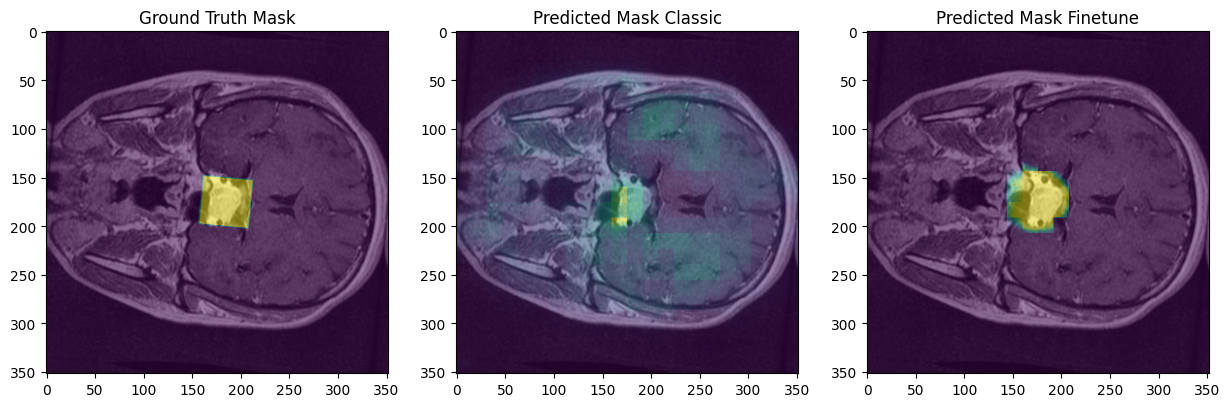

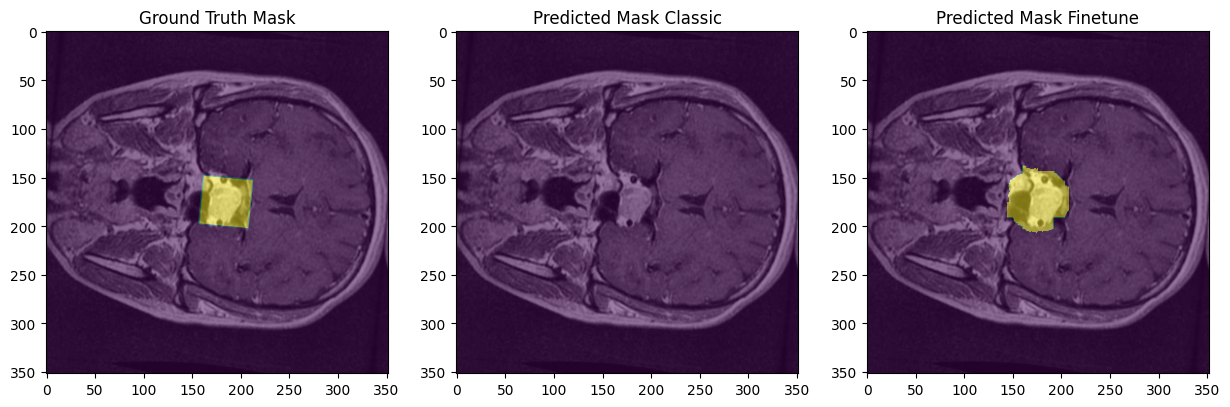

  1%|          | 1/101 [02:02<3:24:33, 122.74s/it]

Epoch 1, Training loss: 0.5046463882161203, Validation loss: 0.416751468098247, Test IoU: Finetune 0.43082703924373833 - Classic 0.0045552762416853545


  2%|▏         | 2/101 [04:00<3:18:05, 120.05s/it]

Epoch 2, Training loss: 0.4958120032093338, Validation loss: 0.41135945645245636, Test IoU: Finetune 0.44447571821864085 - Classic 0.0016592909099471848


  3%|▎         | 3/101 [05:58<3:14:26, 119.05s/it]

Epoch 3, Training loss: 0.4869641771567328, Validation loss: 0.4022247766281341, Test IoU: Finetune 0.44280057249097965 - Classic 0.0009704871226748088


  4%|▍         | 4/101 [07:57<3:11:57, 118.74s/it]

Epoch 4, Training loss: 0.4793036750724884, Validation loss: 0.3839038700768442, Test IoU: Finetune 0.4589944729798579 - Classic 0.0010278428273781301


  5%|▍         | 5/101 [09:54<3:09:28, 118.42s/it]

Epoch 5, Training loss: 0.4748638736979463, Validation loss: 0.3807763489254149, Test IoU: Finetune 0.47079233482975325 - Classic 0.0008337155340136427


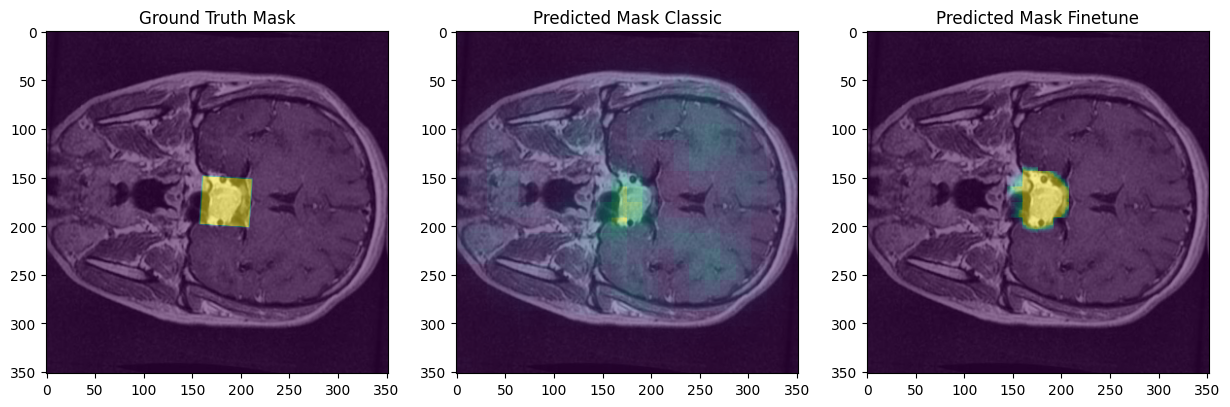

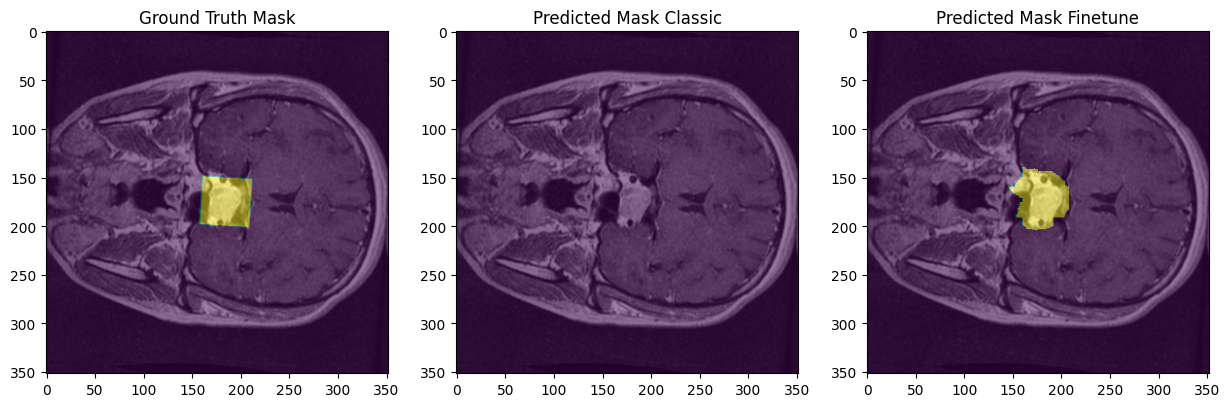

Epoch 6, Training loss: 0.46966037376425396, Validation loss: 0.3769892062340583, Test IoU: Finetune 0.4693344147292579 - Classic 0.003082318270219639


  7%|▋         | 7/101 [13:58<3:08:32, 120.35s/it]

Epoch 7, Training loss: 0.46866695628502714, Validation loss: 0.36538858736033764, Test IoU: Finetune 0.48019076567780106 - Classic 0.0


  8%|▊         | 8/101 [15:57<3:05:28, 119.66s/it]

Epoch 8, Training loss: 0.4611002101641044, Validation loss: 0.37000288690998284, Test IoU: Finetune 0.4793190910928582 - Classic 0.0010851855225567592


  9%|▉         | 9/101 [17:55<3:02:58, 119.33s/it]

Epoch 9, Training loss: 0.45977422634707626, Validation loss: 0.36561433488116674, Test IoU: Finetune 0.47957593376997304 - Classic 0.001901477195062108


 10%|▉         | 10/101 [19:53<3:00:25, 118.96s/it]

Epoch 10, Training loss: 0.4533639078768846, Validation loss: 0.3595987797339201, Test IoU: Finetune 0.48586058127433196 - Classic 3.3981098014229584e-05


 11%|█         | 11/101 [21:52<2:58:11, 118.79s/it]

Epoch 11, Training loss: 0.45189291504664364, Validation loss: 0.3658437174516958, Test IoU: Finetune 0.491690919592899 - Classic 0.0014517422830206393


 12%|█▏        | 12/101 [23:50<2:55:53, 118.58s/it]

Epoch 12, Training loss: 0.4496919306791257, Validation loss: 0.3670623341362515, Test IoU: Finetune 0.4892617189440383 - Classic 0.0011276165960877411


 13%|█▎        | 13/101 [25:48<2:53:50, 118.52s/it]

Epoch 13, Training loss: 0.4515297809707499, Validation loss: 0.35785612123551624, Test IoU: Finetune 0.4972951126641054 - Classic 0.0018696306684747143


 14%|█▍        | 14/101 [27:46<2:51:23, 118.21s/it]

Epoch 14, Training loss: 0.44237566208553697, Validation loss: 0.35347411154589176, Test IoU: Finetune 0.4998465270893239 - Classic 0.00032815114529563294


 15%|█▍        | 15/101 [29:43<2:49:11, 118.04s/it]

Epoch 15, Training loss: 0.4425707566595268, Validation loss: 0.35201724425896064, Test IoU: Finetune 0.5023704230642945 - Classic 0.0015849786734395757


 16%|█▌        | 16/101 [31:41<2:46:52, 117.80s/it]

Epoch 16, Training loss: 0.43941951837742854, Validation loss: 0.3513503705427085, Test IoU: Finetune 0.5061607995119931 - Classic 0.0017520173478853356


 17%|█▋        | 17/101 [33:38<2:44:58, 117.84s/it]

Epoch 17, Training loss: 0.43891992260231955, Validation loss: 0.33977106206622715, Test IoU: Finetune 0.5089892848187856 - Classic 0.00020334548779852674


 18%|█▊        | 18/101 [35:36<2:42:48, 117.70s/it]

Epoch 18, Training loss: 0.4378640463603003, Validation loss: 0.34581089283758665, Test IoU: Finetune 0.5027966446893259 - Classic 0.0006410005862810241


 19%|█▉        | 19/101 [37:34<2:40:52, 117.72s/it]

Epoch 19, Training loss: 0.4354417837174056, Validation loss: 0.33581165889482123, Test IoU: Finetune 0.5097659527816786 - Classic 0.0008476323011096308


 20%|█▉        | 20/101 [39:32<2:39:06, 117.86s/it]

Epoch 20, Training loss: 0.43425238993609155, Validation loss: 0.33521484550618347, Test IoU: Finetune 0.5157686479964775 - Classic 0.0001138674912242203


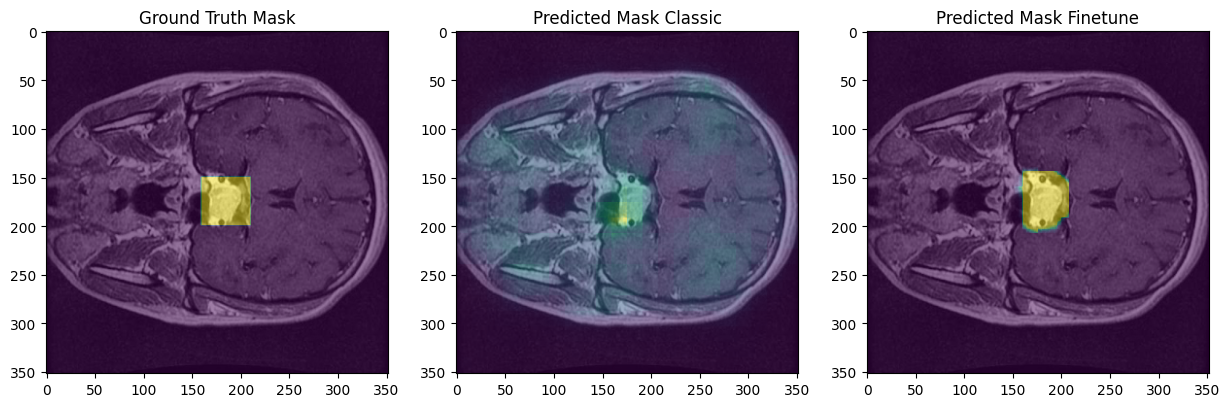

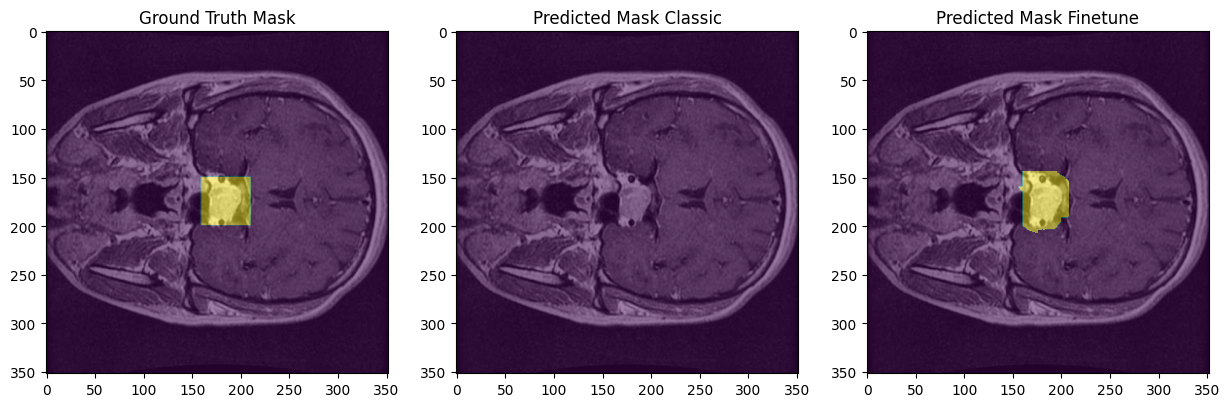

 21%|██        | 21/101 [41:32<2:37:59, 118.49s/it]

Epoch 21, Training loss: 0.4349299494658266, Validation loss: 0.3365518228435294, Test IoU: Finetune 0.5146494651122241 - Classic 0.0006677879316504531


 22%|██▏       | 22/101 [43:29<2:35:40, 118.24s/it]

Epoch 22, Training loss: 0.4323190417731015, Validation loss: 0.3367455515550289, Test IoU: Finetune 0.5101194052921586 - Classic 0.00014726455904265034


 23%|██▎       | 23/101 [45:27<2:33:31, 118.10s/it]

Epoch 23, Training loss: 0.42706417513592104, Validation loss: 0.3347332380312584, Test IoU: Finetune 0.5207098407670966 - Classic 0.001708779564265236


 24%|██▍       | 24/101 [47:24<2:31:16, 117.87s/it]

Epoch 24, Training loss: 0.42684190258998844, Validation loss: 0.34134572786051076, Test IoU: Finetune 0.522333437228029 - Classic 0.002549727995287724


 25%|██▍       | 25/101 [49:22<2:29:14, 117.82s/it]

Epoch 25, Training loss: 0.4267237699936614, Validation loss: 0.33623317238334177, Test IoU: Finetune 0.5316658172163724 - Classic 0.0011957830591548533


 26%|██▌       | 26/101 [51:20<2:27:11, 117.75s/it]

Epoch 26, Training loss: 0.42269633970311415, Validation loss: 0.3314758043189149, Test IoU: Finetune 0.5263635668389733 - Classic 0.000667086081221798


 27%|██▋       | 27/101 [53:20<2:26:08, 118.50s/it]

Epoch 27, Training loss: 0.4221662278975374, Validation loss: 0.3322968699715354, Test IoU: Finetune 0.5382161457065614 - Classic 0.001487060981976963


 28%|██▊       | 28/101 [55:18<2:24:03, 118.41s/it]

Epoch 28, Training loss: 0.42493872739344873, Validation loss: 0.32824061314264935, Test IoU: Finetune 0.5277192418542701 - Classic 0.0008964380691547213


 29%|██▊       | 29/101 [57:17<2:22:06, 118.42s/it]

Epoch 29, Training loss: 0.4180421141111422, Validation loss: 0.32688178410341134, Test IoU: Finetune 0.531823866621447 - Classic 0.0010949496841615206


 30%|██▉       | 30/101 [59:15<2:20:05, 118.38s/it]

Epoch 30, Training loss: 0.4194711686450537, Validation loss: 0.3260770059409953, Test IoU: Finetune 0.5259785102037615 - Classic 0.0002513918024764009


 31%|███       | 31/101 [1:01:13<2:17:59, 118.27s/it]

Epoch 31, Training loss: 0.42057505948407037, Validation loss: 0.32006541860131393, Test IoU: Finetune 0.536215890447853 - Classic 0.0010990019368336285


 32%|███▏      | 32/101 [1:03:11<2:15:55, 118.19s/it]

Epoch 32, Training loss: 0.4184927145904612, Validation loss: 0.32252623095656885, Test IoU: Finetune 0.5238052617038823 - Classic 0.0028573522805297757


 33%|███▎      | 33/101 [1:05:09<2:13:47, 118.06s/it]

Epoch 33, Training loss: 0.41642824112972154, Validation loss: 0.3237138409992476, Test IoU: Finetune 0.5315227781787579 - Classic 0.00036807269617978564


 34%|███▎      | 34/101 [1:07:07<2:11:58, 118.19s/it]

Epoch 34, Training loss: 0.41723943447146056, Validation loss: 0.31840050456685065, Test IoU: Finetune 0.5331369319597222 - Classic 0.0009667149349826508


 35%|███▍      | 35/101 [1:09:07<2:10:25, 118.57s/it]

Epoch 35, Training loss: 0.4120441589469757, Validation loss: 0.3191382540411605, Test IoU: Finetune 0.5258092555453672 - Classic 0.0038388058969551007


 36%|███▌      | 36/101 [1:11:05<2:08:25, 118.55s/it]

Epoch 36, Training loss: 0.4115515292563864, Validation loss: 0.3194954759313232, Test IoU: Finetune 0.5281304937346555 - Classic 0.0019694182173140163


 37%|███▋      | 37/101 [1:13:04<2:06:24, 118.50s/it]

Epoch 37, Training loss: 0.4118986595645249, Validation loss: 0.31667514308627115, Test IoU: Finetune 0.5305081973609764 - Classic 0.0012721964630230387


 38%|███▊      | 38/101 [1:15:03<2:04:34, 118.64s/it]

Epoch 38, Training loss: 0.41253659648996854, Validation loss: 0.3149876137435575, Test IoU: Finetune 0.5379857873926105 - Classic 0.0


 39%|███▊      | 39/101 [1:17:00<2:02:17, 118.35s/it]

Epoch 39, Training loss: 0.4092617879774218, Validation loss: 0.31493457477965275, Test IoU: Finetune 0.5415875104110742 - Classic 0.0010278428273781301


 40%|███▉      | 40/101 [1:18:59<2:00:25, 118.45s/it]

Epoch 40, Training loss: 0.4112287829227041, Validation loss: 0.31772828643972223, Test IoU: Finetune 0.5412987740580398 - Classic 0.00016804621746592367


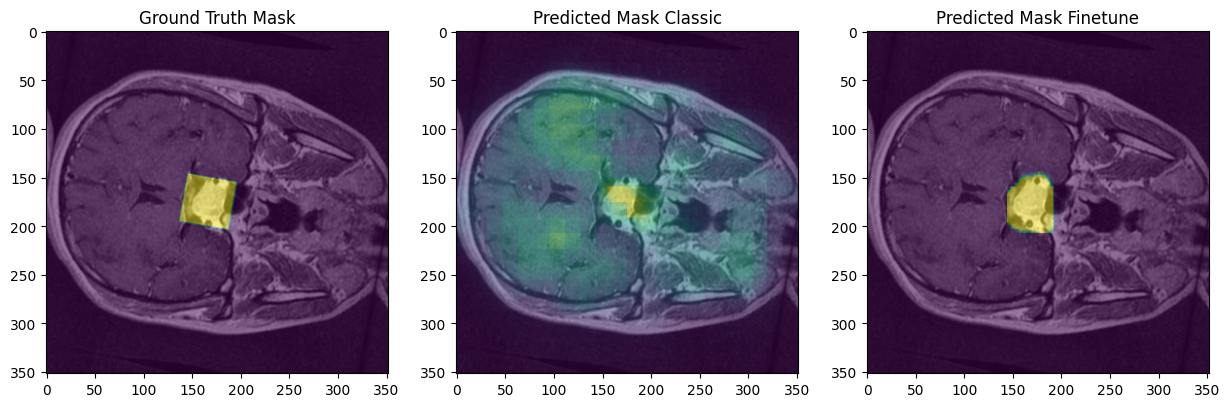

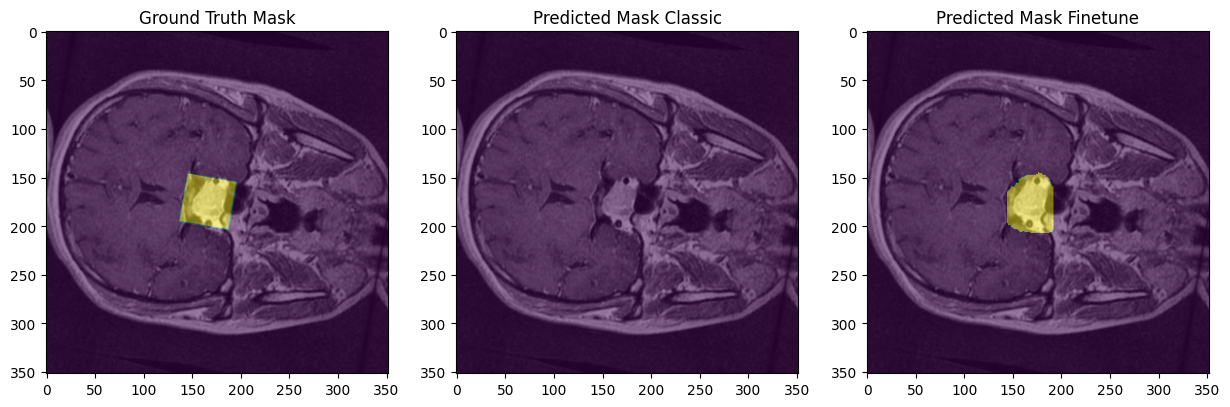

Epoch 41, Training loss: 0.4085166884881361, Validation loss: 0.3201563883494664, Test IoU: Finetune 0.5419690697237872 - Classic 0.003724737407724079


 42%|████▏     | 42/101 [1:23:03<1:58:17, 120.29s/it]

Epoch 42, Training loss: 0.4061942200924204, Validation loss: 0.31975135561469553, Test IoU: Finetune 0.5450622835350208 - Classic 0.00011097231354639594


 43%|████▎     | 43/101 [1:25:02<1:55:53, 119.90s/it]

Epoch 43, Training loss: 0.41031411333820633, Validation loss: 0.31304110416443476, Test IoU: Finetune 0.5535600845338184 - Classic 0.0007418804303024293


 44%|████▎     | 44/101 [1:27:00<1:53:25, 119.40s/it]

Epoch 44, Training loss: 0.40763094878387196, Validation loss: 0.31756521299446655, Test IoU: Finetune 0.5375590387432407 - Classic 0.0008213861496761779


 45%|████▍     | 45/101 [1:28:59<1:51:19, 119.28s/it]

Epoch 45, Training loss: 0.40398754697347605, Validation loss: 0.3132935588732188, Test IoU: Finetune 0.5442443977309295 - Classic 0.003039185195300351


 46%|████▌     | 46/101 [1:30:58<1:49:08, 119.07s/it]

Epoch 46, Training loss: 0.4060884461739409, Validation loss: 0.3102887043586144, Test IoU: Finetune 0.5424419155813839 - Classic 0.001247048537108191


 47%|████▋     | 47/101 [1:32:57<1:47:05, 118.99s/it]

Epoch 47, Training loss: 0.40115462674123153, Validation loss: 0.31112063069999357, Test IoU: Finetune 0.5521331134247726 - Classic 0.0014199443361773841


 48%|████▊     | 48/101 [1:34:55<1:45:00, 118.87s/it]

Epoch 48, Training loss: 0.4031545588878119, Validation loss: 0.3137937259007167, Test IoU: Finetune 0.545340642998475 - Classic 0.002807118739042223


 49%|████▊     | 49/101 [1:36:54<1:42:57, 118.80s/it]

Epoch 49, Training loss: 0.4006852740136666, Validation loss: 0.31762737799913454, Test IoU: Finetune 0.5492625363845302 - Classic 0.0017031971032722972


 50%|████▉     | 50/101 [1:38:53<1:40:58, 118.79s/it]

Epoch 50, Training loss: 0.4040476302014845, Validation loss: 0.31765572452322866, Test IoU: Finetune 0.5561230274686858 - Classic 0.0011554812767933212


 50%|█████     | 51/101 [1:40:51<1:38:56, 118.73s/it]

Epoch 51, Training loss: 0.4058243370405367, Validation loss: 0.3135282020746689, Test IoU: Finetune 0.5502799127791966 - Classic 0.0007733859770912878


 51%|█████▏    | 52/101 [1:42:50<1:37:01, 118.80s/it]

Epoch 52, Training loss: 0.40545121966284536, Validation loss: 0.30160306383679797, Test IoU: Finetune 0.5639812842672003 - Classic 0.001402563590235226


 52%|█████▏    | 53/101 [1:44:49<1:35:01, 118.78s/it]

Epoch 53, Training loss: 0.40327426719760767, Validation loss: 0.31205247651724827, Test IoU: Finetune 0.5450841858289437 - Classic 0.0014134757770259665


 53%|█████▎    | 54/101 [1:46:47<1:32:57, 118.66s/it]

Epoch 54, Training loss: 0.4030412911337003, Validation loss: 0.3093894874299323, Test IoU: Finetune 0.553647499006214 - Classic 0.0012382001391901237


 54%|█████▍    | 55/101 [1:48:46<1:31:00, 118.71s/it]

Epoch 55, Training loss: 0.4047995024371877, Validation loss: 0.3079972212964838, Test IoU: Finetune 0.5533647356469994 - Classic 0.001023950017355085


 55%|█████▌    | 56/101 [1:50:45<1:28:59, 118.64s/it]

Epoch 56, Training loss: 0.40434468867934337, Validation loss: 0.306295731267729, Test IoU: Finetune 0.5586472539227033 - Classic 0.002864635938754951


 56%|█████▋    | 57/101 [1:52:43<1:26:58, 118.60s/it]

Epoch 57, Training loss: 0.40200061721109676, Validation loss: 0.3039322778895185, Test IoU: Finetune 0.5551572323631129 - Classic 0.0008621805310043248


 57%|█████▋    | 58/101 [1:54:42<1:25:02, 118.67s/it]

Epoch 58, Training loss: 0.4016338784034338, Validation loss: 0.3073158052973536, Test IoU: Finetune 0.5525234311090117 - Classic 0.0007733859770912878


 58%|█████▊    | 59/101 [1:56:41<1:23:02, 118.63s/it]

Epoch 59, Training loss: 0.4035962477981171, Validation loss: 0.3042361755749007, Test IoU: Finetune 0.5479977144029784 - Classic 0.0016079668338712487


 59%|█████▉    | 60/101 [1:58:39<1:21:04, 118.65s/it]

Epoch 60, Training loss: 0.3998575507007172, Validation loss: 0.30548594464788903, Test IoU: Finetune 0.5625312759062172 - Classic 0.0010724103700845886


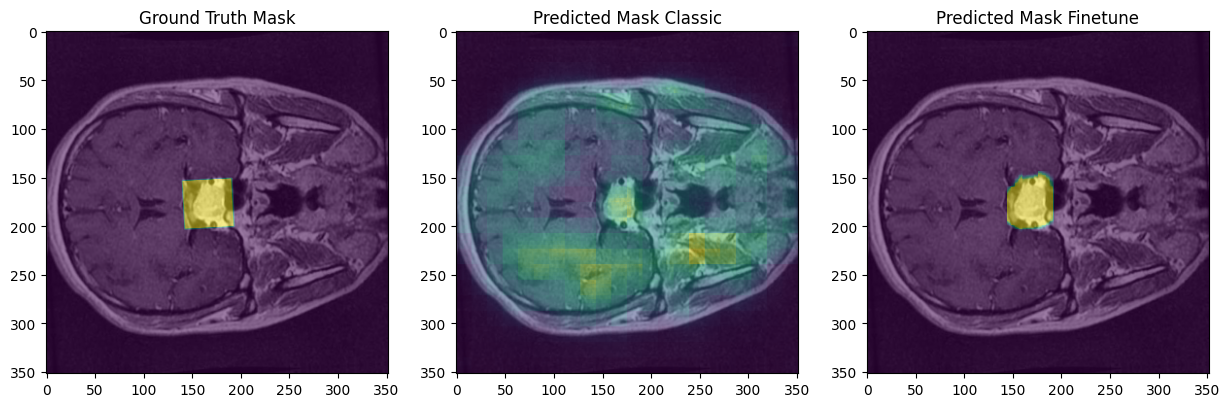

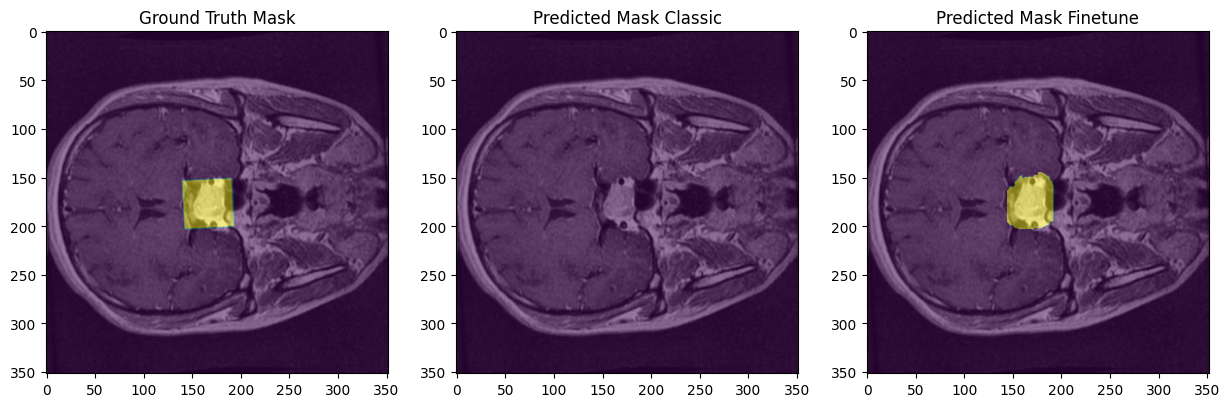

 60%|██████    | 61/101 [2:00:40<1:19:31, 119.29s/it]

Epoch 61, Training loss: 0.4021052058622459, Validation loss: 0.30568192735974326, Test IoU: Finetune 0.555514060529127 - Classic 0.0022993341679417257


 61%|██████▏   | 62/101 [2:02:39<1:17:33, 119.33s/it]

Epoch 62, Training loss: 0.4029112328067124, Validation loss: 0.3029955379612796, Test IoU: Finetune 0.5527057479633376 - Classic 0.0010022660852042672


 62%|██████▏   | 63/101 [2:04:39<1:15:39, 119.45s/it]

Epoch 63, Training loss: 0.4015576966037446, Validation loss: 0.30148212101076033, Test IoU: Finetune 0.5499366768808962 - Classic 0.0007481503900220516


 63%|██████▎   | 64/101 [2:06:39<1:13:39, 119.43s/it]

Epoch 64, Training loss: 0.40158668477906684, Validation loss: 0.30717963827795636, Test IoU: Finetune 0.5517385133474093 - Classic 0.0007901381732852314


 64%|██████▍   | 65/101 [2:08:38<1:11:38, 119.40s/it]

Epoch 65, Training loss: 0.40378713028408714, Validation loss: 0.3117749239459182, Test IoU: Finetune 0.5603573057310038 - Classic 0.0011712145763977352


 65%|██████▌   | 66/101 [2:10:40<1:10:05, 120.15s/it]

Epoch 66, Training loss: 0.40188157280656533, Validation loss: 0.3105577704234001, Test IoU: Finetune 0.5466329235014971 - Classic 0.0


 66%|██████▋   | 67/101 [2:12:40<1:08:09, 120.29s/it]

Epoch 67, Training loss: 0.40061837601439454, Validation loss: 0.3046536627627197, Test IoU: Finetune 0.55216049146734 - Classic 0.001023950017355085


 67%|██████▋   | 68/101 [2:14:41<1:06:07, 120.22s/it]

Epoch 68, Training loss: 0.40219999085888564, Validation loss: 0.3022890321580402, Test IoU: Finetune 0.5608626799675255 - Classic 0.0013532698033597106


 68%|██████▊   | 69/101 [2:16:41<1:04:08, 120.25s/it]

Epoch 69, Training loss: 0.40000993172116034, Validation loss: 0.30804240203403926, Test IoU: Finetune 0.5539860324267784 - Classic 0.0007733859770912878


 69%|██████▉   | 70/101 [2:18:41<1:02:08, 120.26s/it]

Epoch 70, Training loss: 0.3985613166650983, Validation loss: 0.3143872015681856, Test IoU: Finetune 0.5664835157758006 - Classic 0.0007421380007003413


 70%|███████   | 71/101 [2:20:42<1:00:10, 120.35s/it]

Epoch 71, Training loss: 0.4016917699503994, Validation loss: 0.3062682479689449, Test IoU: Finetune 0.5519624868461395 - Classic 0.0016452375746132198


 71%|███████▏  | 72/101 [2:22:42<58:11, 120.41s/it]  

Epoch 72, Training loss: 0.4021563726798513, Validation loss: 0.30387340267221413, Test IoU: Finetune 0.5583004796135868 - Classic 0.001023950017355085


 72%|███████▏  | 73/101 [2:24:42<56:08, 120.32s/it]

Epoch 73, Training loss: 0.4024554747795455, Validation loss: 0.30515942623565245, Test IoU: Finetune 0.5647307723578481 - Classic 0.0017269237717341475


 73%|███████▎  | 74/101 [2:26:42<54:03, 120.13s/it]

Epoch 74, Training loss: 0.40081225948708354, Validation loss: 0.3023854521882562, Test IoU: Finetune 0.5554168302122057 - Classic 0.0002934145256335627


 74%|███████▍  | 75/101 [2:28:42<52:05, 120.20s/it]

Epoch 75, Training loss: 0.39890757127703425, Validation loss: 0.30812691836368233, Test IoU: Finetune 0.5507067427941947 - Classic 0.0006316493170080562


 75%|███████▌  | 76/101 [2:30:43<50:05, 120.24s/it]

Epoch 76, Training loss: 0.39947402401865717, Validation loss: 0.3028591386366002, Test IoU: Finetune 0.5687517078658049 - Classic 0.0012233147858240832


 76%|███████▌  | 77/101 [2:32:42<48:01, 120.08s/it]

Epoch 77, Training loss: 0.40266388079297843, Validation loss: 0.30435789465070606, Test IoU: Finetune 0.5607927726599609 - Classic 0.0004045765403708394


 77%|███████▋  | 78/101 [2:34:43<46:02, 120.10s/it]

Epoch 78, Training loss: 0.4029611717765722, Validation loss: 0.30379536490896086, Test IoU: Finetune 0.5688075347984282 - Classic 0.0


 78%|███████▊  | 79/101 [2:36:42<43:59, 119.96s/it]

Epoch 79, Training loss: 0.39966713215476185, Validation loss: 0.3064860122187154, Test IoU: Finetune 0.5537557607145405 - Classic 0.0010268377831261569


 79%|███████▉  | 80/101 [2:38:42<41:57, 119.86s/it]

Epoch 80, Training loss: 0.4008187525043792, Validation loss: 0.3033488396998052, Test IoU: Finetune 0.5630629182038857 - Classic 0.001002699255768927


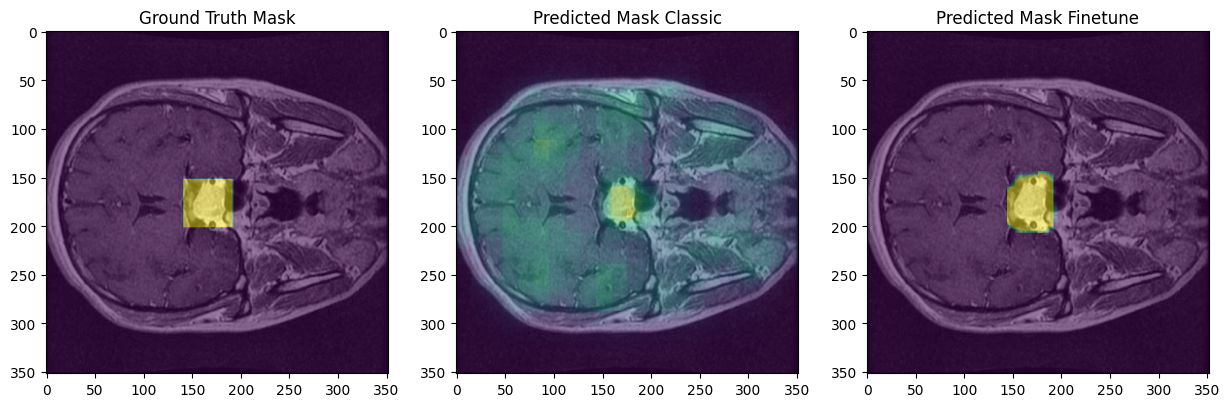

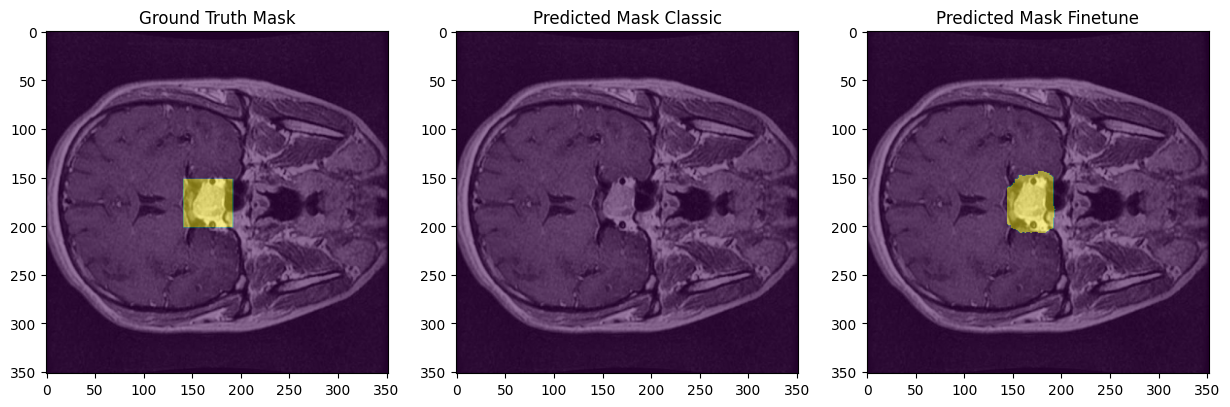

Epoch 81, Training loss: 0.4008596012103415, Validation loss: 0.29921316280787363, Test IoU: Finetune 0.5585701083601885 - Classic 0.0007740881453869849


 81%|████████  | 82/101 [2:43:02<39:22, 124.34s/it]

Epoch 82, Training loss: 0.40153498560706086, Validation loss: 0.30085324907636307, Test IoU: Finetune 0.5679447670812994 - Classic 0.0020110456489780405


 82%|████████▏ | 83/101 [2:45:01<36:49, 122.77s/it]

Epoch 83, Training loss: 0.4006921121188391, Validation loss: 0.2994784004204757, Test IoU: Finetune 0.5675773973453709 - Classic 0.001308086667502822


 83%|████████▎ | 84/101 [2:47:00<34:26, 121.57s/it]

Epoch 84, Training loss: 0.4022105575084051, Validation loss: 0.30014761622413333, Test IoU: Finetune 0.5589889158756293 - Classic 0.0009691124877593724


 84%|████████▍ | 85/101 [2:49:00<32:18, 121.16s/it]

Epoch 85, Training loss: 0.39934804884793756, Validation loss: 0.3028120456875621, Test IoU: Finetune 0.5650645775647296 - Classic 0.0007733859770912878


 85%|████████▌ | 86/101 [2:51:00<30:11, 120.78s/it]

Epoch 86, Training loss: 0.40041142392571216, Validation loss: 0.2981005901501173, Test IoU: Finetune 0.5603633867212076 - Classic 0.002349794831519479


 86%|████████▌ | 87/101 [2:53:01<28:10, 120.78s/it]

Epoch 87, Training loss: 0.39756984058296313, Validation loss: 0.3051956108400038, Test IoU: Finetune 0.5589170722561455 - Classic 0.0008928454653708846


 87%|████████▋ | 88/101 [2:55:01<26:10, 120.78s/it]

Epoch 88, Training loss: 0.40150353899808444, Validation loss: 0.30095334958919, Test IoU: Finetune 0.5601355652752011 - Classic 0.0018615019463832335


In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
new_size = (352, 352)
model = model.to(device)
model_class = model_class.to(device)

num_epochs = 101
# Define an augmentation pipeline
transform = A.Compose([
    A.Resize(new_size[0], new_size[1]),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=10),
], additional_targets={'mask': 'image'})  # Định nghĩa rằng 'mask' cũng là một hình ảnh và cần được xử lý tương tự

epochs = []
train_losses = []
val_losses = []
iou_scoress_finetune = []
iou_scoress_classic = []
visualization_data = {
    'image': [],
    'mask_gt': [],
    'mask_pred_classic': [],
    'mask_pred_finetune': []
}
texts = ['tumor in brain']

for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0
    for i in range(len(imgs_train)):
        augmented = transform(image=np.array(imgs_train[i]), mask=np.array(msks_train[i]))
        img_transformed = augmented['image']
        mask_transformed = augmented['mask']
        inputs = processor(text=texts, images=[img_transformed] * len(texts), padding=True, return_tensors="pt").to(device)
        outputs = model(**inputs, interpolate_pos_encoding=True)
        mask_tensor = torch.from_numpy(mask_transformed).to(device).unsqueeze(0)
        mask_resize = mask_tensor.detach().cpu().numpy()
        loss = dice_loss(outputs.logits, torch.unsqueeze(mask_tensor[0],0).to(device))
        train_loss += loss.item()
#         if i < 20 and epoch == 0:
#             visualize_masks(img_transformed,mask_resize[0],outputs.logits.detach().cpu().numpy(),mask_transformed)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(imgs_train)

    # Giả sử dice_loss là hàm mất mát DiceLoss bạn đã khởi tạo
    model.eval()  # Chuyển mô hình sang mode đánh giá
    model_class.eval()
    val_loss = 0
    iou_scores_finetune = 0
    iou_scores_classic = 0

    with torch.no_grad():  # Không tính toán gradient trong block này
        for i in range(len(imgs_val)):
            augmented = transform(image=np.array(imgs_val[i]), mask=np.array(msks_val[i]))
            img_transformed = augmented['image']
            mask_transformed = augmented['mask']
            inputs = processor(text=texts, images=[img_transformed] * len(texts), padding=True, return_tensors="pt").to(device)
            outputs = model(**inputs, interpolate_pos_encoding=True)
            mask_tensor = torch.from_numpy(mask_transformed).to(device).unsqueeze(0)
            loss = dice_loss(outputs.logits, torch.unsqueeze(mask_tensor[0],0).to(device))
            val_loss += loss.item()

        val_loss /= len(imgs_val)

        for i in range(len(imgs_test)):
            augmented = transform(image=np.array(imgs_test[i]), mask=np.array(msks_test[i]))
            img_transformed = augmented['image']
            mask_transformed = augmented['mask']

            inputs = processor(text=texts, images=[img_transformed] * len(texts), padding=True, return_tensors="pt").to(device)

            preds_finetune = model(**inputs, interpolate_pos_encoding=True)[0]
            preds_classic = model_class(**inputs, interpolate_pos_encoding=True)[0]

            preds_sigmods_finetune = torch.sigmoid(preds_finetune)
            preds_sigmods_classic = torch.sigmoid(preds_classic)

            preds_seg_finetune = np.squeeze(preds_sigmods_finetune.cpu().detach().numpy(), 0)
            preds_seg_classic = np.squeeze(preds_sigmods_classic.cpu().detach().numpy(), 0)

            mask_tensor = torch.from_numpy(mask_transformed).to(device)
            mask_resize = mask_tensor.detach().cpu().numpy()

            if i == 2 and (epoch == 0 or epoch == 5 or epoch == 20 or epoch == 40 or epoch == 60 or epoch == 80 or epoch == 99):
                visualize_masks(img_transformed,mask_resize,preds_seg_classic,preds_seg_finetune)
                visualization_data['image'].append(img_transformed)
                visualization_data['mask_gt'].append(mask_resize)
                visualization_data['mask_pred_classic'].append(preds_seg_classic)
                visualization_data['mask_pred_finetune'].append(preds_seg_finetune)


            preds_seg_finetune = (preds_seg_finetune > 0.5).astype(np.uint8)
            preds_seg_classic = (preds_seg_classic > 0.5).astype(np.uint8)

            if i == 2 and (epoch == 0 or epoch == 5 or epoch == 20 or epoch == 40 or epoch == 60 or epoch == 80 or epoch == 99):
                visualize_masks(img_transformed,mask_resize,preds_seg_classic,preds_seg_finetune)
                visualization_data['image'].append(img_transformed)
                visualization_data['mask_gt'].append(mask_resize)
                visualization_data['mask_pred_classic'].append(preds_seg_classic)
                visualization_data['mask_pred_finetune'].append(preds_seg_finetune)

            iou_scores_finetune += evaluate_predictions(mask_resize,preds_seg_finetune)
            iou_scores_classic += evaluate_predictions(mask_resize,preds_seg_classic)

        iou_scores_finetune /= len(imgs_test)
        iou_scores_classic /= len(imgs_test)

    message = f'Epoch {epoch+1}, Training loss: {train_loss}, Validation loss: {val_loss}, Test IoU: Finetune {iou_scores_finetune} - Classic {iou_scores_classic}'
    print(message)

    scheduler.step()
    epochs.append(epoch+1)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    iou_scoress_finetune.append(iou_scores_finetune)
    iou_scoress_classic.append(iou_scores_classic)

    if epoch == 5 or epoch == 40 or epoch == 80:
        torch.save(model.state_dict(), work_path+'/fine_tuned_CLIPSeg_{}.pth'.format(epoch))

torch.save(model.state_dict(), work_path+'/fine_tuned_CLIPSeg.pth')
